In [ ]:
# Imports

import torch
import torchtext
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import codecs
import re
import nltk
from nltk.corpus import wordnet as wn

glove = torchtext.vocab.GloVe(name="6B", dim=50) 
nltk.download('wordnet')

.vector_cache/glove.6B.zip: 862MB [06:52, 2.09MB/s]                          
 99%|█████████▉| 397378/400000 [00:13<00:00, 29198.68it/s]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# NOTE: we downloaded the meanGrades for the dev.csv from the competition website, this
# data can be found at <data/task1/dev.csv> in the shared drive link
train_df = pd.read_csv('data/task-1/train.csv')
test_df = pd.read_csv('data/task-1/dev.csv')

##Preliminary dataset analysis

In [ ]:
# We define a function to print some dataset stats 
def gradeStats(dataframe):
  print('funniness score distribution stats: mean', dataframe['meanGrade'].mean(),
      '| median', dataframe['meanGrade'].median(),
      '| std', dataframe['meanGrade'].std())

TRAIN SET
funniness score distribution stats: mean 0.9355712114932938 | median 0.8 | std 0.5836430877881352

DEV SET
funniness score distribution stats: mean 0.9347664324100872 | median 0.8 | std 0.5785188808912749



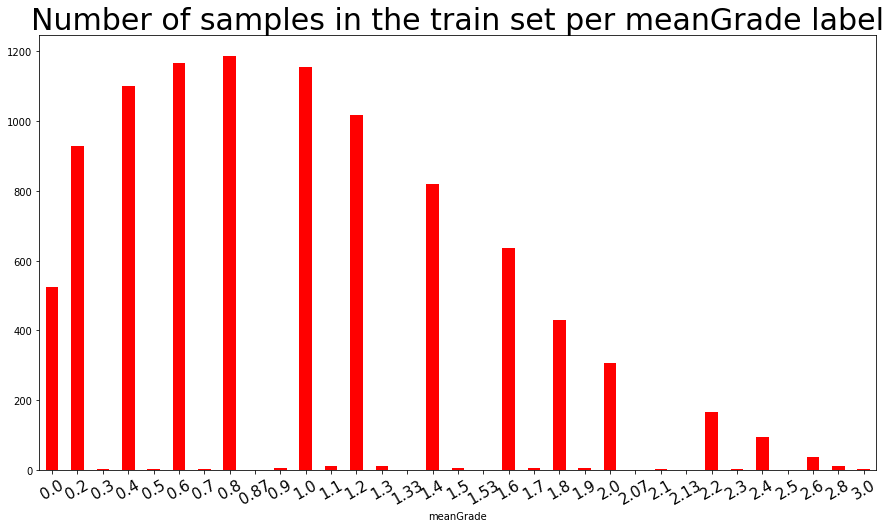

In [17]:
#First we look at the distribution of samples for each label in the train set

#mean, mode and std of train and test set
print('\033[1m' + 'TRAIN SET' + '\033[0m')
gradeStats(train_df)
print()
print('\033[1m' + 'DEV SET' + '\033[0m')
gradeStats(test_df)
print()

#plot distribution of the train set
fig, ax = plt.subplots()
train_df.groupby('meanGrade').size().plot(kind='bar', figsize=(15,8), xlim=(0,1200), 
                                          rot=30, color=r'red', legend=False);
plt.title('Number of samples in the train set per meanGrade label', fontsize=30)
labels = [item.get_text() for item in ax.get_xticklabels()];
ax.set_xticklabels([str(round(float(label), 2)) for label in labels], fontsize=15);
#fig.savefig('traindistribution.pdf')

##Data exploration 1: check if headlines where the word Trump appears are funnier

In [ ]:
#create a dataframe of those data samples where the word 'Trump' or 'trump' appears 
#anywhere (context or edit)
trump_df = train_df[train_df.apply(lambda row: row.astype(str).str.contains('trump|Trump').any(), axis=1)]

#proportion of headlines containing Trump in the train set
len(trump_df)/len(train_df) #0.389, the proportion of data about Trump is rather high

0.38893493576460836

In [ ]:
#call the function gradeStats defined above to print some statistics about the 
#Trump dataframe, and the trainset as a whole for comparison
print('\033[1m' + 'Whole train set' + '\033[0m')
gradeStats(train_df)
print()
print('\033[1m' + 'Headlines about Trump' + '\033[0m')
gradeStats(trump_df)

Whole train set
funniness score distribution stats: mean 0.9355712114932938 | median 0.8 | std 0.5836430877881352

Headlines about Trump
funniness score distribution stats: mean 1.0197478245427083 | median 1.0 | std 0.6020856727082561


##Data exploration 2: distance between the original word and the edit and correlation/regression with the funniness score

In [ ]:
#define function to isolate pairs of original and edited word
def createPairs(dataframe):
  word_pairs = []
  for row in dataframe.itertuples(index=False):
    words = row.original.split(' ')
    pair = []
    for word in words:
      if word.startswith('<'):
         original_word = re.sub(r'[^\w]', '', word)
         new_word = row.edit
    pair.append(original_word.lower())
    pair.append(new_word.lower())
    word_pairs.append(pair)
  return word_pairs


#define a function to create, from a list of word pairs, a column of distances 
#(using vector norm and GloVe 6B 50d embeddings) and add it to an input dataframe
#add it to a dataframe
def createDistanceDataframe(word_pairs, dataframe):
  distance_list = []
  for pair in word_pairs:
    x = glove[pair[0]]
    y = glove[pair[1]]
    d = torch.norm(y - x)
    dist = float(d)
    distance_list.append(dist)
  dic = {'distance':distance_list}
  distance_df = pd.DataFrame(dic) 
  return dataframe.join(distance_df)

In [ ]:
#append new columns with distances between original word and edit to both the train 
#and test set dataframes

#add column to train set
pairs = createPairs(train_df)
train_df_dist = createDistanceDataframe(pairs, train_df)

#add column to test set
pairs = createPairs(test_df)
test_df_dist = createDistanceDataframe(pairs, test_df)

In [ ]:
#bin the distances into 5 bins from 1 to 10 (there are no distances lower than 1)
bins = np.arange(1, 10, 2).tolist()
train_df_dist['binned'] = pd.cut(train_df_dist['distance'], bins) #add column to identify which distance bin each row belongs to

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


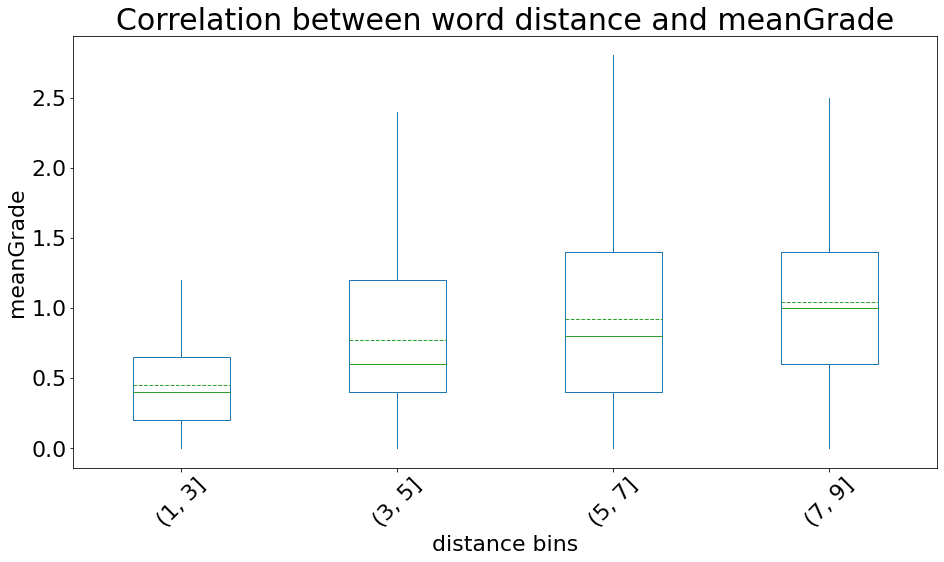

In [ ]:
#box-and-whisker plot to show correlation between distance from original to edited word and meanGrade
fig = train_df_dist.boxplot(column='meanGrade', by='binned', fontsize=22, rot=45, grid=False, figsize=(15,8), 
                            showfliers=False, showcaps=False, showmeans=True, meanline=True)
plt.title('Correlation between word distance and meanGrade', fontsize=30)
plt.suptitle('')
plt.xlabel('distance bins', fontsize=22)
plt.ylabel('meanGrade', fontsize=22)
fig.figure.savefig("boxplot.pdf")

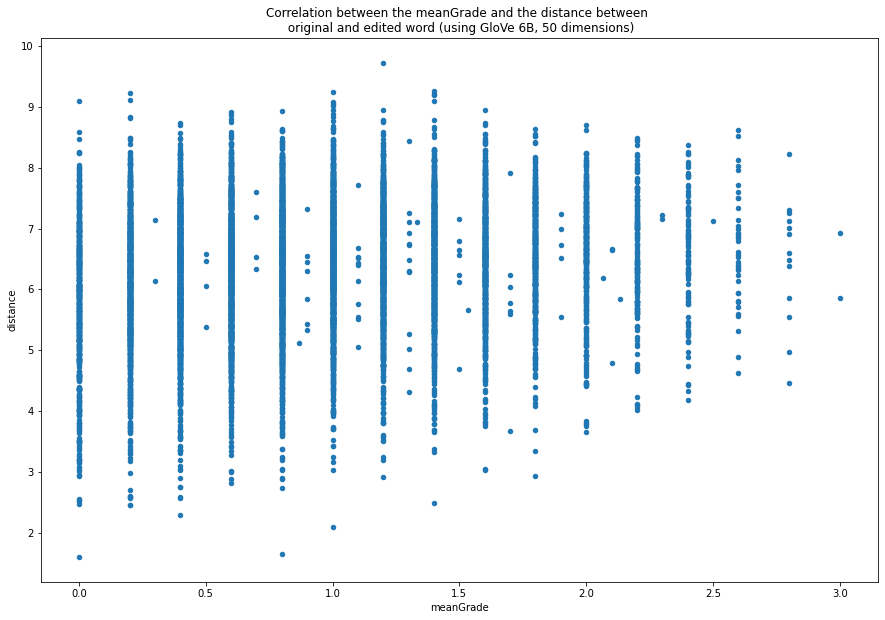

In [ ]:
#scatter plot between meanGrade and distance (this is less representative than the box-and-whisker plot)
train_df_dist.plot(x='meanGrade', y='distance', kind='scatter', figsize=(15,10),
                   title='Correlation between the meanGrade and the distance between \n original and edited word (using GloVe 6B, 50 dimensions)');

Mean squared error: 0.33
Root mean squared error: 0.57
Coefficient of determination: 0.02



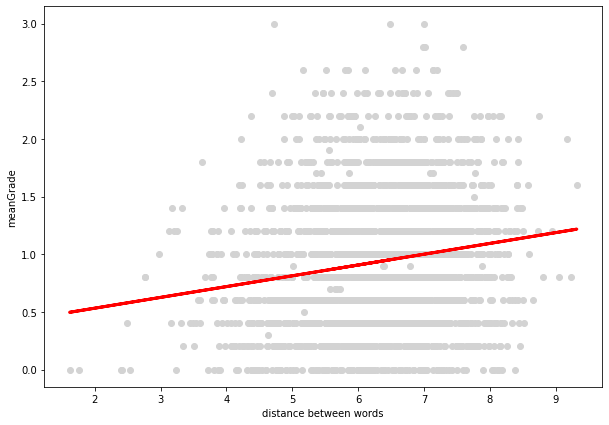

In [ ]:
#linear regression of distance and meanGrade 
#(we did not report on this in our final submitted report, as the box-and-whisker plot is more representative)

#define X (distance) and y (meanGrade) for the train set
X_train = train_df_dist.iloc[:, 5].values.reshape(-1, 1)  
y_train = train_df_dist.iloc[:, 4].values.reshape(-1, 1) 
#and for the test set
X_test = test_df_dist.iloc[:, 5].values.reshape(-1, 1)
y_test = test_df_dist.iloc[:, 4].values.reshape(-1, 1)

regr = LinearRegression()
#train the model using the training sets
regr.fit(X_train, y_train)
#make predictions using the test set
y_pred = regr.predict(X_test)

#mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
#root mean squared error
print('Root mean squared error: %.2f' 
      %np.sqrt(mean_squared_error(y_test, y_pred)))
#r2 score: coefficient of determination (1 is a perfect prediction)
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print()

#plot outputs
plt.figure(figsize=(10,7))
plt.scatter(X_test, y_test, color='lightgrey')
plt.plot(X_test, y_pred, color='red', linewidth=3)
plt.xlabel("distance between words")
plt.ylabel("meanGrade")
plt.show()

##Data exploration 3: check if the headlines where the substituted word comes from taboo domain are funnier

In [ ]:
#create a list of taboo words. Societal taboos used: sex, genitals, human physiology.
#using WordNet, we start from hyponyms of the word 'sex' and add synonim sets of a further
#initial list of 10 taboo words
init = wn.synset('sex.n.01')
taboos = list(set([w for s in init.closure(lambda s:s.hyponyms()) for w in s.lemma_names()])) #find hyponims of 'sex'

starting_words = ['sex', 'genitals', 'penis', 'vagina', 'ass', 'toilet', 'poop', 'piss', 'fart', 'fuck'] #some taboo words! 

for word in starting_words:
  for ss in (wn.synsets(word)):
    for i in ss.lemma_names():
      if i not in taboos:
        taboos.append(i)

#remove words that are not taboo, or are too generic/have too many meanings (can skew results too much at next step)
to_remove = ['can', 'head', 'wind', 'john', 'quarter', 'tail', 'water', 'love', 'make', 'know', 'jazz', 'AS', 'seat', 
             'American_Samoa', 'member', 'Eastern_Samoa', 'fundament', 'As', 'congress', 'multiplication', 'puddle']
taboos = list(set(taboos) - set(to_remove))
#print("we have " + str(len(taboos)) + " initial taboo words. They are:")
#for i in taboos:
#  print(i)
len(taboos)

262

taboo samples: 323	mean: 1.0870	std:0.6189
non-taboo samples: 9329	mean: 0.9303	std:0.5816


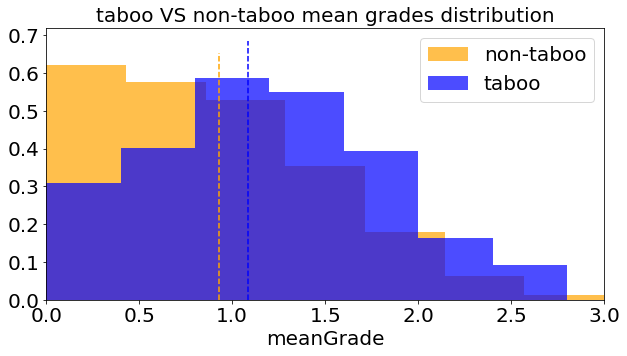

top 10 edits: 
edit
buttock      2.8
fault        2.8
sexy         2.6
skydivers    2.6
biceps       2.6
coherence    2.6
tequila      2.6
dealer       2.6
midlife      2.6
enjoyment    2.6
Name: meanGrade, dtype: float64
bottom 10 edits: 
edit
zoos         0.0
sow          0.0
sparklers    0.0
juggled      0.0
speedy       0.0
spends       0.0
drifting     0.0
spitball     0.0
spits        0.0
border       0.0
Name: meanGrade, dtype: float64


In [ ]:
#inspect distribution differences between all data and sentences containing taboo words

# 1. convert all sentences in train df to lower characters
train_df["original"] = train_df.apply(lambda x: x['original'].lower(), axis=1)
train_df["edit"] = train_df.apply(lambda x: x['edit'].lower(), axis=1)

# 2. retirieve data containing taboo words and data not containing taboo words
taboo_df = train_df[train_df['edit'].str.contains("|".join(taboos))]
non_taboo_df = train_df[~train_df['edit'].str.contains("|".join(taboos))]
taboo_labels = taboo_df['meanGrade']
non_taboo_labels = non_taboo_df['meanGrade']

# 3. fit a gaussian to the data
from scipy.stats import norm
taboo_mean, taboo_std = norm.fit(taboo_labels)
non_taboo_mean, non_taboo_std = norm.fit(non_taboo_labels)
#all_mean, all_std = norm.fit(train_labels)
xx = np.linspace(0, 3)
#print("all samples: %d\tmean: %.4f\tstd:%.4f"%(len(train_df), all_mean, all_std))
print("taboo samples: %d\tmean: %.4f\tstd:%.4f"%(len(taboo_df), taboo_mean, taboo_std))
print("non-taboo samples: %d\tmean: %.4f\tstd:%.4f"%(len(non_taboo_df), non_taboo_mean, non_taboo_std))

# 4. plot
fig = plt.figure(figsize=(10, 5))

plt.hist(non_taboo_labels, color='orange', alpha=0.7, bins=7, label="non-taboo", density=True)
#plt.plot(xx, norm.pdf(xx, non_taboo_mean, non_taboo_std), 'orange', ls="--")
plt.plot([non_taboo_mean, non_taboo_mean], plt.ylim(), 'orange', ls="--")

plt.hist(taboo_labels, color='b', alpha=0.7, bins=7, label="taboo", density=True)
#plt.plot(xx, norm.pdf(xx, taboo_mean, taboo_std), 'b--')
plt.plot([taboo_mean, taboo_mean], plt.ylim(), 'b', ls="--")

plt.title("taboo VS non-taboo mean grades distribution", fontsize=20)
plt.xlabel("meanGrade", fontsize=20)
plt.xlim([0,3])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.show()

#inspect funniest edits
top_edits = train_df.groupby('edit')['meanGrade'].mean().sort_values(ascending=False)
bottom_edits = train_df.groupby('edit')['meanGrade'].mean().sort_values(ascending=True)

#print the edits that received the highest and lowest scores for inspection
print("top 10 edits: ")
print(top_edits.head(10))
print("bottom 10 edits: ")
print(bottom_edits.head(10))

##Search for a reasonable baseline to compare our models to

In [ ]:
#we try three possible baselines: 
#(1) predict a random grade in the most likely continuous range
#(2) predict a random grade from a discrete choice among the most likely grades
#(3) predict the mean of all meanGrades every time


#initialise arrays for each approach
y_pred_random = []
y_pred_random_discrete = []
y_pred_mean = []

y_test = test_df_dist.iloc[:, 4].values.reshape(-1, 1) #column 4 is meanGrade
mean = train_df['meanGrade'].mean()
#populate arrays
for i in range(len(y_test)):
  y_pred_random.append(np.random.uniform(0.4, 1.4))
  y_pred_random_discrete.append(np.random.choice([0.4, 0.6, 0.8, 1.0, 1.2, 1.4]))
  y_pred_mean.append(mean)

#print MSE, RMSE and R2 of each possible baseline
print('\033[1m' + 'When predicting a random grade in the most likely (continuous) range [0.4, 1.4]' + '\033[0m')
print('MSE:', mean_squared_error(y_test, y_pred_random))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_random)))
print('R2 score:', r2_score(y_test, y_pred_random))
print()
print('\033[1m' + 'When predicting a random grade (discrete choice) among the most likely ones' + '\033[0m')
print('MSE:', mean_squared_error(y_test, y_pred_random_discrete))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_random_discrete)))
print('R2 score:', r2_score(y_test, y_pred_random_discrete))
print()
print('\033[1m' + 'When predicting the mean of all grades every time' + '\033[0m')
print('MSE:', mean_squared_error(y_test, y_pred_mean))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_mean)))
print('R2 score:', r2_score(y_test, y_pred_mean)) 

#we choose the last approach (predict the mean each time) as baseline. Note that
#the R2 is very small at -1.94e-06 so it can be rounded to zero

When predicting a random grade in the most likely (continuous) range [0.4, 1.4]
MSE: 0.4112945751648142
RMSE: 0.6413225203942352
R2 score: -0.22941208635426924

When predicting a random grade (discrete choice) among the most likely ones
MSE: 0.446812732534105
RMSE: 0.6684405228096999
R2 score: -0.33558040121069777

When predicting the mean of all grades every time
MSE: 0.3345463868319654
RMSE: 0.5783998503042385
R2 score: -1.935966586819049e-06
